<a href="https://colab.research.google.com/github/f4falalu/EDSA/blob/main/NLP_South_African_Language_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# South African Language Identification Using Natural Language Processing (NLP)

## Overview

South Africa is a multiracial, multicultural country with a vast spectrum of languages. Language is a critical tool for developing democracy and contributing to the social, cultural, intellectual, economic, and political life of South African society.

In this tutorial, we will explore how NLP is used to determine the language a piece of text is written in, we will explore and utilize the nltk library.

Data Source: https://www.kaggle.com/competitions/south-african-language-identification/data

In [4]:
#Import packages and dependecies

import pandas as pd
import numpy as np
import time, os

#Packages for visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style

#Packages for preprocessing
import nltk
import re
from sklearn.feature_extraction.text import TfidfVectorizer

#Packages for trainig models
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

from lightgbm import LGBMClassifier


from sklearn import metrics
from sklearn import tree
import xgboost as xgb

# Model Evaluation Packages
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.metrics import make_scorer


In [5]:
#Download additional nltk package
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

2. Load Dataset

In [6]:
df_train = pd.read_csv('/content/train_set.csv')
df_test = pd.read_csv('/content/test_set.csv')

In [7]:
df_train.head(4)

,lang_id,text
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...
2,eng,the province of kwazulu-natal department of tr...
3,nso,o netefatša gore o ba file dilo ka moka tše le...


In [8]:
df_test.head(4)

,index,text
0,1,"Mmasepala, fa maemo a a kgethegileng a letlele..."
1,2,Uzakwaziswa ngokufaneleko nakungafuneka eminye...
2,3,Tshivhumbeo tshi fana na ngano dza vhathu.
3,4,Kube inja nelikati betingevakala kutsi titsini...


3. EDA

Quick overview of the dataset

In [9]:
#info into language id
df_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33000 entries, 0 to 32999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   lang_id  33000 non-null  object
 1   text     33000 non-null  object
dtypes: object(2)
memory usage: 515.8+ KB


In [10]:
print('shape of train dataset', df_train.shape)
df_train.lang_id.value_counts()


shape of train dataset (33000, 2)


xho    3000
eng    3000
nso    3000
ven    3000
tsn    3000
nbl    3000
zul    3000
ssw    3000
tso    3000
sot    3000
afr    3000
Name: lang_id, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


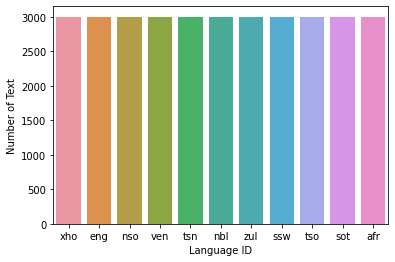

In [11]:
#plotting sentiment graph

sns.countplot(df_train.lang_id,)
plt.xlabel('Language ID')
plt.ylabel('Number of Text')
plt.show()

Data Preprocessing

Involves cleaning and transforming the dataset, removing stopwords and preparing the dataset for preprocessing.

In [12]:
stopword=nltk.corpus.stopwords.words('english')
stopword.remove('not')

def processed_text(text):
  #Removing special characters
  text=re.sub(r'@[\w]*','',text)
  #Removing urls from text
  text=re.sub(r'http/S+','',text)
  #Removing Punctuations, Numbers, and Special Characters
  text=re.sub(r'[^A-Za-z#]',' ',text)   
  #Removing stopword
  
  #text=" ".join(i.lower() for i in text.split() if i.lower() not in stopword) 
   
  text = text.lower()
    # will split and join the words
  text=' '.join(text.split())
  return text
   
    
    
    

In [13]:
# Application of the function to clean the text
df_train['text'] = df_train['text'].apply(processed_text)
df_test['text'] = df_test['text'].apply(processed_text)

In [14]:
# Replace '.txt' with 'text file'
df_train["text"] = df_train["text"].str.replace(".txt", " text file")
df_test["text"] = df_test["text"].str.replace(".txt", " text file")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


Feature Engineering

Data Splitting

In [15]:
X = df_train['text']
y = df_train['lang_id']

Splitting of Training and Validation Sets

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=45)

Model Building

Build pipeline for classifier models

In [17]:
#Setting up classifier for model building

classifiers = [
    LogisticRegression(),
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MultinomialNB(),
    LGBMClassifier()
]

In [18]:
#creating pipeline for modeling building

def models_building(classifiers, X_train, y_train, X_val, y_val):
    
    models_summary = {}

    # Pipeline to balance the classses and then to build the model
    for clf in classifiers:
        clf_text = Pipeline([('tfidf', TfidfVectorizer(min_df=1,
                                                       max_df=0.9,
                                                       ngram_range=(1, 2))),
                             ('clf', clf)])

        # Logging the Execution Time for each model
        start_time = time.time()
        clf_text.fit(X_train, y_train)
        predictions = clf_text.predict(X_val)
        run_time = time.time()-start_time

        # Output for each model
        models_summary[clf.__class__.__name__] = {
            'F1-Macro': metrics.f1_score(y_val,
                                         predictions,
                                         average='macro'),
            'F1-Accuracy': metrics.f1_score(y_val, predictions,
                                            average='micro'),
            'F1-Weighted': metrics.f1_score(y_val,
                                            predictions,
                                            average='weighted'),
            'Execution Time': run_time}

    return pd.DataFrame.from_dict(models_summary, orient='index')

In [19]:
classifiers_df = models_building(classifiers, X_train, y_train, X_test, y_test)
ordered_df = classifiers_df.sort_values('F1-Macro', ascending=False)
ordered_df

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


,F1-Macro,F1-Accuracy,F1-Weighted,Execution Time
MultinomialNB,0.997945,0.997939,0.997937,6.493015
LogisticRegression,0.993817,0.993818,0.993811,158.471617
SVC,0.992277,0.992242,0.992274,617.065975
LGBMClassifier,0.979326,0.979394,0.979349,120.979508
KNeighborsClassifier,0.956425,0.956848,0.956581,10.676832
DecisionTreeClassifier,0.516687,0.566303,0.516822,9.032937
RandomForestClassifier,0.024939,0.094061,0.024640,6.509215


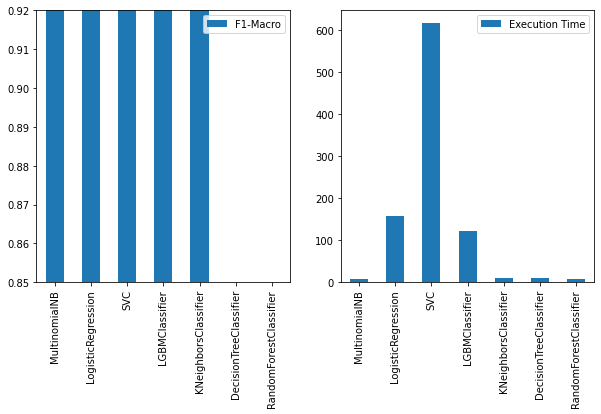

In [20]:

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ordered_df.sort_values('F1-Macro', ascending=False, inplace=True)
ordered_df.plot(y=['F1-Macro'], kind='bar', ax=ax[0], xlim=[0,1.1], ylim=[0.85,0.92])
ordered_df.plot(y='Execution Time', kind='bar', ax=ax[1])

Hyperparameter Tuning on Most Performing Models

In [25]:
# Refining the train-test split for validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

Multinomial Naive Bayes (MNB)

In [26]:
# Creating a pipeline for the gridsearch
param_grid = {'alpha': [0.1, 1, 5, 10]}  # setting parameter grid

#Applying TF-IDF Vectorizer

tuned_mnb = Pipeline([('tfidf', TfidfVectorizer(min_df=2,
                                                max_df=0.9,
                                                ngram_range=(1, 2))),
                   ('mnb', GridSearchCV(MultinomialNB(),
                                           param_grid=param_grid,
                                           cv=5,
                                           n_jobs=-1,
                                           scoring='f1_macro'))
])
# Fitting the model
tuned_mnb.fit(X_train, y_train)

# predicting the fit on validation set
mnb_predicted = tuned_mnb.predict(X_test)  

print(classification_report(y_test, mnb_predicted))

              precision    recall  f1-score   support

         afr       1.00      1.00      1.00       778
         eng       1.00      1.00      1.00       749
         nbl       1.00      0.99      1.00       756
         nso       1.00      1.00      1.00       785
         sot       1.00      1.00      1.00       712
         ssw       1.00      1.00      1.00       735
         tsn       1.00      1.00      1.00       743
         tso       1.00      1.00      1.00       736
         ven       1.00      1.00      1.00       780
         xho       1.00      1.00      1.00       734
         zul       0.99      1.00      1.00       742

    accuracy                           1.00      8250
   macro avg       1.00      1.00      1.00      8250
weighted avg       1.00      1.00      1.00      8250



In [27]:
#Model evaluation for Logistic Regression
mnb_acc = (metrics.accuracy_score(y_test, mnb_predicted))*100
print('The Multinomial Naive Bayes regression has:',mnb_acc,'% accuracy')

The Multinomial Naive Bayes regression has: 99.87878787878788 % accuracy


Creating File for Kaggle Submission (OPTIONAL)

In [24]:
submission_df = pd.DataFrame(df_test['index'])
submission_df['lang_id'] = tuned_mnb.predict(df_test['text'])
submission_df.to_csv('sub_SA_Lang_Predict2.csv', index=False)